# READ

1. API is in User Variables for User in Environemtn Variables named "NEPTUNE_API_TOKEN"
2. If internet sucks, set mode to offline
4. When offline runs are saved locally, sync it with | neptune sync -p "New-Thesis/KFold-Test" --offline-only |
- make sure it is in venv mode | (venv) PS C:\Users\user\Documents\Machine-Learning-Hub-1\ImageClassification\Neptune-Thesis> |
5. Delete the offline folder or use | neptune clear |

# Load Libraries

In [1]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools
from numpy.random import default_rng

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy
from tensorboard.plugins.hparams import api as hp
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold

from time import perf_counter
import math

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

# Initialize Functions

In [38]:
model_name = "V4.1.2"
checkpoint_path = f'./checkpoints/{model_name}/FOLD-'

In [45]:
def make_model(params):
    model = Sequential()
    model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
    model.add(RandomRotation(factor=0.2, seed=1))
    
    model.add(Conv2D(input_shape=(256,256,3), filters=32, kernel_size=(3,3), padding="same"))
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=640,activation="relu"))
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=256,activation="relu"))
    
    model.add(Dense(units=4, activation="softmax"))


    optimizer = tf.keras.optimizers.Adam(
        learning_rate=params["lr"],
    )
    
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [4]:
def create_callbacks(counter):
    neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + str(counter), 
                                                                 monitor='val_loss', 
                                                                 mode='auto', 
                                                                 save_best_only=True, 
                                                                 verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   patience=23,
                                                  )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                         factor=0.6, 
                                                         patience=10, 
                                                         min_delta=0.001, 
                                                         mode='auto', 
                                                         verbose=1)
    return [neptune_cbk, reduce_lr, cp_callback, es_callback]

In [5]:
def plot_loss(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    plt.suptitle('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return fig

In [6]:
def plot_acc(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['accuracy'], color='teal', label='acc')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
    plt.suptitle('Accuracy')
    plt.legend(loc='upper left')
    plt.show()
    return fig

In [7]:
def avg_rate(metric_list):
    return sum(metric_list) / len(metric_list)

# Prepare Dataset

In [8]:
labels = ['Building', 'Plant', 'Road', 'Vehicle']
X_train = []
y_train = []
y_label_idx = []
image_size = 256
for i in labels:
    folderPath = os.path.join('D:\DATASETS\For-Thesis\Labels', i)
    for j in os.listdir(folderPath):
        img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_label_idx.append(labels.index(i))

In [9]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0

In [10]:
rng = default_rng(seed=1)

buildings_test_idx = rng.choice(np.arange(0,600), size=120, replace=False)
plants_test_idx = rng.choice(np.arange(600,1200), size=120, replace=False)
roads_test_idx = rng.choice(np.arange(1200,1800), size=120, replace=False)
vehicles_test_idx = rng.choice(np.arange(1800,2400), size=120, replace=False)
total_test_idx = np.concatenate((buildings_test_idx, plants_test_idx, roads_test_idx, vehicles_test_idx), axis=None)

In [11]:
def train_test_X(X_train_scaled):    
    test_x = X_train_scaled[total_test_idx]
    train_x = np.delete(X_train_scaled, total_test_idx, axis=0)
    return train_x, test_x

def train_test_y(y_label_idx):
    test_y = y_label_idx[total_test_idx]
    train_y = np.delete(y_label_idx, total_test_idx, axis=0)
    return train_y, test_y

In [12]:
train_x, holdout_x = train_test_X(X_train_scaled)
train_y, holdout_y = train_test_y(y_label_idx)

In [13]:
print(len(train_x), len(holdout_x))

1920 480


In [23]:
print(train_y[:5])

[0 0 0 0 0]


In [30]:
# Inidices remain the same thanks to the seed (set to 1)
# with open('total_test_idx.txt', 'w+') as f:
     
#     # write elements of list
#     for items in total_test_idx:
#         f.write('%s ' %items)
     
#     print("File written successfully")
 
 
# # close the file
# f.close()

# Run KFOLD

In [46]:
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=1)

In [47]:
project_name = "New-Thesis/KFold-Test"
# api_token = <It is already initialized in environemnt variables>
params = {
    "lr": 0.0015, 
    "epochs": 45, 
    "batch_size": 8}

In [42]:
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING

[neptune] [info   ] Neptune initialized. Open in the app: offline/406072f7-0a80-45b0-91a3-4a11b2f6f44e
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 18.9290 - accuracy: 0.4946
Epoch 1: val_loss improved from inf to 3.64022, saving model to ./checkpoints/V4.1.2\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-0\assets


210/210 [==============================] - 524s 2s/step - loss: 18.9290 - accuracy: 0.4946 - val_loss: 3.6402 - val_accuracy: 0.3083 - lr: 0.0015
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.8117 - accuracy: 0.4911
Epoch 2: val_loss improved from 3.64022 to 1.06746, saving model to ./checkpoints/V4.1.2\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-0\assets


210/210 [==============================] - 483s 2s/step - loss: 1.8117 - accuracy: 0.4911 - val_loss: 1.0675 - val_accuracy: 0.5417 - lr: 0.0015
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 1.1490 - accuracy: 0.4685
Epoch 3: val_loss did not improve from 1.06746
210/210 [==============================] - 434s 2s/step - loss: 1.1490 - accuracy: 0.4685 - val_loss: 1.2275 - val_accuracy: 0.5000 - lr: 0.0015
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 1.0872 - accuracy: 0.5268
Epoch 4: val_loss did not improve from 1.06746
210/210 [==============================] - 436s 2s/step - loss: 1.0872 - accuracy: 0.5268 - val_loss: 2.5254 - val_accuracy: 0.3958 - lr: 0.0015
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 1.1446 - accuracy: 0.5006
Epoch 5: val_loss did not improve from 1.06746
210/210 [==============================] - 448s 2s/step - loss: 1.1446 - accuracy: 0.5006 - val_loss: 1.7615 - val_accuracy: 0.5542 - lr

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-0\assets


210/210 [==============================] - 435s 2s/step - loss: 1.1683 - accuracy: 0.4107 - val_loss: 1.0350 - val_accuracy: 0.4583 - lr: 9.0000e-04
Epoch 15/45
210/210 [==============================] - ETA: 0s - loss: 1.1083 - accuracy: 0.4333
Epoch 15: val_loss did not improve from 1.03505
210/210 [==============================] - 424s 2s/step - loss: 1.1083 - accuracy: 0.4333 - val_loss: 1.0837 - val_accuracy: 0.4500 - lr: 9.0000e-04
Epoch 16/45
210/210 [==============================] - ETA: 0s - loss: 1.1375 - accuracy: 0.4387
Epoch 16: val_loss did not improve from 1.03505
210/210 [==============================] - 423s 2s/step - loss: 1.1375 - accuracy: 0.4387 - val_loss: 3.6257 - val_accuracy: 0.2708 - lr: 9.0000e-04
Epoch 17/45
210/210 [==============================] - ETA: 0s - loss: 1.0985 - accuracy: 0.4327
Epoch 17: val_loss did not improve from 1.03505
210/210 [==============================] - 420s 2s/step - loss: 1.0985 - accuracy: 0.4327 - val_loss: 1.0960 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-0\assets


210/210 [==============================] - 434s 2s/step - loss: 1.0864 - accuracy: 0.4137 - val_loss: 0.9713 - val_accuracy: 0.4750 - lr: 9.0000e-04
Epoch 23/45
210/210 [==============================] - ETA: 0s - loss: 1.0696 - accuracy: 0.4458
Epoch 23: val_loss did not improve from 0.97134
210/210 [==============================] - 434s 2s/step - loss: 1.0696 - accuracy: 0.4458 - val_loss: 1.1081 - val_accuracy: 0.4208 - lr: 9.0000e-04
Epoch 24/45
210/210 [==============================] - ETA: 0s - loss: 1.1072 - accuracy: 0.4351
Epoch 24: val_loss did not improve from 0.97134
210/210 [==============================] - 431s 2s/step - loss: 1.1072 - accuracy: 0.4351 - val_loss: 1.5588 - val_accuracy: 0.3792 - lr: 9.0000e-04
Epoch 25/45
210/210 [==============================] - ETA: 0s - loss: 1.0988 - accuracy: 0.4536
Epoch 25: val_loss did not improve from 0.97134
210/210 [==============================] - 422s 2s/step - loss: 1.0988 - accuracy: 0.4536 - val_loss: 1.0251 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-0\assets


210/210 [==============================] - 435s 2s/step - loss: 0.8783 - accuracy: 0.6083 - val_loss: 0.7069 - val_accuracy: 0.7042 - lr: 5.4000e-04
Epoch 37/45
210/210 [==============================] - ETA: 0s - loss: 0.8768 - accuracy: 0.6077
Epoch 37: val_loss did not improve from 0.70690
210/210 [==============================] - 422s 2s/step - loss: 0.8768 - accuracy: 0.6077 - val_loss: 0.7595 - val_accuracy: 0.6875 - lr: 5.4000e-04
Epoch 38/45
210/210 [==============================] - ETA: 0s - loss: 0.8461 - accuracy: 0.6381
Epoch 38: val_loss did not improve from 0.70690
210/210 [==============================] - 425s 2s/step - loss: 0.8461 - accuracy: 0.6381 - val_loss: 0.8398 - val_accuracy: 0.6083 - lr: 5.4000e-04
Epoch 39/45
210/210 [==============================] - ETA: 0s - loss: 0.8330 - accuracy: 0.6387
Epoch 39: val_loss did not improve from 0.70690
210/210 [==============================] - 424s 2s/step - loss: 0.8330 - accuracy: 0.6387 - val_loss: 5.1832 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-0\assets


210/210 [==============================] - 431s 2s/step - loss: 0.6994 - accuracy: 0.7304 - val_loss: 0.5816 - val_accuracy: 0.7750 - lr: 5.4000e-04
Epoch 43/45
210/210 [==============================] - ETA: 0s - loss: 0.7178 - accuracy: 0.7054
Epoch 43: val_loss did not improve from 0.58163
210/210 [==============================] - 422s 2s/step - loss: 0.7178 - accuracy: 0.7054 - val_loss: 1.5029 - val_accuracy: 0.3417 - lr: 5.4000e-04
Epoch 44/45
210/210 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.7363
Epoch 44: val_loss did not improve from 0.58163
210/210 [==============================] - 422s 2s/step - loss: 0.6562 - accuracy: 0.7363 - val_loss: 1.2072 - val_accuracy: 0.5792 - lr: 5.4000e-04
Epoch 45/45
210/210 [==============================] - ETA: 0s - loss: 0.6381 - accuracy: 0.7369
Epoch 45: val_loss did not improve from 0.58163
210/210 [==============================] - 423s 2s/step - loss: 0.6381 - accuracy: 0.7369 - val_loss: 0.9555 - val_acc

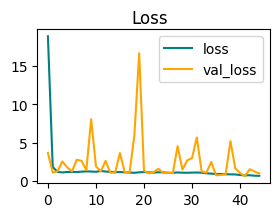

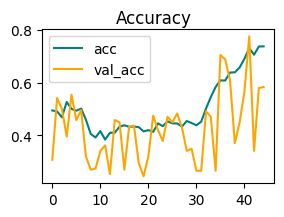

Fold Training Time: 5 hour(s) and 23 mins
Precision: 84.04255509376526  -  Recall: 65.83333611488342
Accuracy: 77.49999761581421
F1Score: Building 65.71427917480469 | Plant 89.25619506835938 | Road 93.442626953125 | Vehicle 59.7938117980957
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/1338ecdf-1735-49bd-9928-c87e7a1971f3
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 16.8865 - accuracy: 0.5339
Epoch 1: val_loss improved from inf to 5.13804, saving model to ./checkpoints/V4.1.2\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-1\assets


210/210 [==============================] - 481s 2s/step - loss: 16.8865 - accuracy: 0.5339 - val_loss: 5.1380 - val_accuracy: 0.2917 - lr: 0.0015
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.3580 - accuracy: 0.6054
Epoch 2: val_loss improved from 5.13804 to 0.96550, saving model to ./checkpoints/V4.1.2\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-1\assets


210/210 [==============================] - 468s 2s/step - loss: 1.3580 - accuracy: 0.6054 - val_loss: 0.9655 - val_accuracy: 0.6208 - lr: 0.0015
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 0.9568 - accuracy: 0.6339
Epoch 3: val_loss did not improve from 0.96550
210/210 [==============================] - 461s 2s/step - loss: 0.9568 - accuracy: 0.6339 - val_loss: 1.2161 - val_accuracy: 0.5292 - lr: 0.0015
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 0.9172 - accuracy: 0.6256
Epoch 4: val_loss did not improve from 0.96550
210/210 [==============================] - 461s 2s/step - loss: 0.9172 - accuracy: 0.6256 - val_loss: 10.5622 - val_accuracy: 0.2667 - lr: 0.0015
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 0.8482 - accuracy: 0.6440
Epoch 5: val_loss did not improve from 0.96550
210/210 [==============================] - 461s 2s/step - loss: 0.8482 - accuracy: 0.6440 - val_loss: 1.0929 - val_accuracy: 0.6333 - l

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-1\assets


210/210 [==============================] - 476s 2s/step - loss: 0.7656 - accuracy: 0.6923 - val_loss: 0.7793 - val_accuracy: 0.6417 - lr: 0.0015
Epoch 12/45
210/210 [==============================] - ETA: 0s - loss: 0.7134 - accuracy: 0.7173
Epoch 12: val_loss did not improve from 0.77928
210/210 [==============================] - 446s 2s/step - loss: 0.7134 - accuracy: 0.7173 - val_loss: 2.0137 - val_accuracy: 0.4708 - lr: 0.0015
Epoch 13/45
210/210 [==============================] - ETA: 0s - loss: 0.6557 - accuracy: 0.7173
Epoch 13: val_loss did not improve from 0.77928
210/210 [==============================] - 447s 2s/step - loss: 0.6557 - accuracy: 0.7173 - val_loss: 1.0158 - val_accuracy: 0.5875 - lr: 0.0015
Epoch 14/45
210/210 [==============================] - ETA: 0s - loss: 0.7696 - accuracy: 0.7000
Epoch 14: val_loss did not improve from 0.77928
210/210 [==============================] - 446s 2s/step - loss: 0.7696 - accuracy: 0.7000 - val_loss: 1.6493 - val_accuracy: 0.483

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-1\assets


210/210 [==============================] - 455s 2s/step - loss: 0.6601 - accuracy: 0.7339 - val_loss: 0.7223 - val_accuracy: 0.7333 - lr: 0.0015
Epoch 19/45
210/210 [==============================] - ETA: 0s - loss: 0.6305 - accuracy: 0.7440
Epoch 19: val_loss did not improve from 0.72229
210/210 [==============================] - 450s 2s/step - loss: 0.6305 - accuracy: 0.7440 - val_loss: 3.7079 - val_accuracy: 0.3000 - lr: 0.0015
Epoch 20/45
210/210 [==============================] - ETA: 0s - loss: 0.5981 - accuracy: 0.7452
Epoch 20: val_loss did not improve from 0.72229
210/210 [==============================] - 449s 2s/step - loss: 0.5981 - accuracy: 0.7452 - val_loss: 1.6719 - val_accuracy: 0.5250 - lr: 0.0015
Epoch 21/45
210/210 [==============================] - ETA: 0s - loss: 0.5867 - accuracy: 0.7762
Epoch 21: val_loss did not improve from 0.72229
210/210 [==============================] - 449s 2s/step - loss: 0.5867 - accuracy: 0.7762 - val_loss: 1.1543 - val_accuracy: 0.583

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-1\assets


210/210 [==============================] - 458s 2s/step - loss: 0.5828 - accuracy: 0.7560 - val_loss: 0.5592 - val_accuracy: 0.7625 - lr: 0.0015
Epoch 24/45
210/210 [==============================] - ETA: 0s - loss: 0.5387 - accuracy: 0.7792
Epoch 24: val_loss improved from 0.55924 to 0.44221, saving model to ./checkpoints/V4.1.2\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-1\assets


210/210 [==============================] - 466s 2s/step - loss: 0.5387 - accuracy: 0.7792 - val_loss: 0.4422 - val_accuracy: 0.8500 - lr: 0.0015
Epoch 25/45
210/210 [==============================] - ETA: 0s - loss: 0.5508 - accuracy: 0.7917
Epoch 25: val_loss did not improve from 0.44221
210/210 [==============================] - 467s 2s/step - loss: 0.5508 - accuracy: 0.7917 - val_loss: 1.8355 - val_accuracy: 0.3875 - lr: 0.0015
Epoch 26/45
210/210 [==============================] - ETA: 0s - loss: 0.5210 - accuracy: 0.7958
Epoch 26: val_loss did not improve from 0.44221
210/210 [==============================] - 455s 2s/step - loss: 0.5210 - accuracy: 0.7958 - val_loss: 1.1415 - val_accuracy: 0.4667 - lr: 0.0015
Epoch 27/45
210/210 [==============================] - ETA: 0s - loss: 0.5273 - accuracy: 0.7976
Epoch 27: val_loss did not improve from 0.44221
210/210 [==============================] - 450s 2s/step - loss: 0.5273 - accuracy: 0.7976 - val_loss: 1.3811 - val_accuracy: 0.483

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-1\assets


210/210 [==============================] - 457s 2s/step - loss: 0.3630 - accuracy: 0.8661 - val_loss: 0.4356 - val_accuracy: 0.8708 - lr: 9.0000e-04
Epoch 41/45
210/210 [==============================] - ETA: 0s - loss: 0.3623 - accuracy: 0.8631
Epoch 41: val_loss improved from 0.43562 to 0.40775, saving model to ./checkpoints/V4.1.2\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-1\assets


210/210 [==============================] - 456s 2s/step - loss: 0.3623 - accuracy: 0.8631 - val_loss: 0.4078 - val_accuracy: 0.8583 - lr: 9.0000e-04
Epoch 42/45
210/210 [==============================] - ETA: 0s - loss: 0.3548 - accuracy: 0.8661
Epoch 42: val_loss did not improve from 0.40775
210/210 [==============================] - 447s 2s/step - loss: 0.3548 - accuracy: 0.8661 - val_loss: 0.9924 - val_accuracy: 0.6958 - lr: 9.0000e-04
Epoch 43/45
210/210 [==============================] - ETA: 0s - loss: 0.3910 - accuracy: 0.8500
Epoch 43: val_loss did not improve from 0.40775
210/210 [==============================] - 448s 2s/step - loss: 0.3910 - accuracy: 0.8500 - val_loss: 0.5751 - val_accuracy: 0.8167 - lr: 9.0000e-04
Epoch 44/45
210/210 [==============================] - ETA: 0s - loss: 0.3386 - accuracy: 0.8708
Epoch 44: val_loss did not improve from 0.40775
210/210 [==============================] - 448s 2s/step - loss: 0.3386 - accuracy: 0.8708 - val_loss: 3.8993 - val_acc

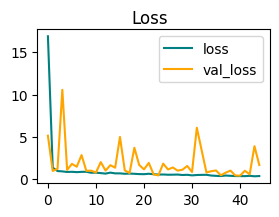

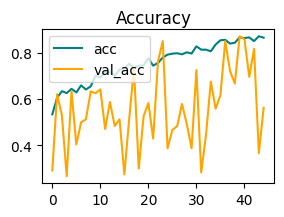

Fold Training Time: 5 hour(s) and 40 mins
Precision: 86.7521345615387  -  Recall: 84.58333611488342
Accuracy: 85.83333492279053
F1Score: Building 77.69784545898438 | Plant 94.91525268554688 | Road 91.89189147949219 | Vehicle 80.35714721679688
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/cae9f2ab-9403-4d74-8cda-fb418acc3c50
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 23.0431 - accuracy: 0.4804
Epoch 1: val_loss improved from inf to 6.11522, saving model to ./checkpoints/V4.1.2\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-2\assets


210/210 [==============================] - 500s 2s/step - loss: 23.0431 - accuracy: 0.4804 - val_loss: 6.1152 - val_accuracy: 0.3750 - lr: 0.0015
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.9954 - accuracy: 0.5720
Epoch 2: val_loss improved from 6.11522 to 0.90423, saving model to ./checkpoints/V4.1.2\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-2\assets


210/210 [==============================] - 468s 2s/step - loss: 1.9954 - accuracy: 0.5720 - val_loss: 0.9042 - val_accuracy: 0.6000 - lr: 0.0015
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 1.0791 - accuracy: 0.6012
Epoch 3: val_loss did not improve from 0.90423
210/210 [==============================] - 459s 2s/step - loss: 1.0791 - accuracy: 0.6012 - val_loss: 2.5662 - val_accuracy: 0.3750 - lr: 0.0015
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 0.9965 - accuracy: 0.6071
Epoch 4: val_loss did not improve from 0.90423
210/210 [==============================] - 457s 2s/step - loss: 0.9965 - accuracy: 0.6071 - val_loss: 7.1472 - val_accuracy: 0.2667 - lr: 0.0015
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 0.8959 - accuracy: 0.6494
Epoch 5: val_loss did not improve from 0.90423
210/210 [==============================] - 461s 2s/step - loss: 0.8959 - accuracy: 0.6494 - val_loss: 3.1633 - val_accuracy: 0.3625 - lr

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-2\assets


210/210 [==============================] - 470s 2s/step - loss: 0.8909 - accuracy: 0.6095 - val_loss: 0.7549 - val_accuracy: 0.6333 - lr: 0.0015
Epoch 8/45
210/210 [==============================] - ETA: 0s - loss: 0.9016 - accuracy: 0.6458
Epoch 8: val_loss did not improve from 0.75488
210/210 [==============================] - 457s 2s/step - loss: 0.9016 - accuracy: 0.6458 - val_loss: 1.5012 - val_accuracy: 0.5833 - lr: 0.0015
Epoch 9/45
210/210 [==============================] - ETA: 0s - loss: 0.8779 - accuracy: 0.6506
Epoch 9: val_loss did not improve from 0.75488
210/210 [==============================] - 458s 2s/step - loss: 0.8779 - accuracy: 0.6506 - val_loss: 1.2152 - val_accuracy: 0.5750 - lr: 0.0015
Epoch 10/45
210/210 [==============================] - ETA: 0s - loss: 0.8302 - accuracy: 0.6571
Epoch 10: val_loss did not improve from 0.75488
210/210 [==============================] - 460s 2s/step - loss: 0.8302 - accuracy: 0.6571 - val_loss: 1.1135 - val_accuracy: 0.5500 - 

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-2\assets


210/210 [==============================] - 466s 2s/step - loss: 0.6116 - accuracy: 0.7458 - val_loss: 0.6990 - val_accuracy: 0.7542 - lr: 9.0000e-04
Epoch 26/45
210/210 [==============================] - ETA: 0s - loss: 0.6628 - accuracy: 0.7411
Epoch 26: val_loss did not improve from 0.69903
210/210 [==============================] - 458s 2s/step - loss: 0.6628 - accuracy: 0.7411 - val_loss: 1.5717 - val_accuracy: 0.5417 - lr: 9.0000e-04
Epoch 27/45
210/210 [==============================] - ETA: 0s - loss: 0.6059 - accuracy: 0.7649
Epoch 27: val_loss improved from 0.69903 to 0.55414, saving model to ./checkpoints/V4.1.2\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-2\assets


210/210 [==============================] - 470s 2s/step - loss: 0.6059 - accuracy: 0.7649 - val_loss: 0.5541 - val_accuracy: 0.8083 - lr: 9.0000e-04
Epoch 28/45
210/210 [==============================] - ETA: 0s - loss: 0.5973 - accuracy: 0.7595
Epoch 28: val_loss improved from 0.55414 to 0.53092, saving model to ./checkpoints/V4.1.2\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-2\assets


210/210 [==============================] - 471s 2s/step - loss: 0.5973 - accuracy: 0.7595 - val_loss: 0.5309 - val_accuracy: 0.8042 - lr: 9.0000e-04
Epoch 29/45
210/210 [==============================] - ETA: 0s - loss: 0.5280 - accuracy: 0.7911
Epoch 29: val_loss improved from 0.53092 to 0.48139, saving model to ./checkpoints/V4.1.2\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-2\assets


210/210 [==============================] - 471s 2s/step - loss: 0.5280 - accuracy: 0.7911 - val_loss: 0.4814 - val_accuracy: 0.8000 - lr: 9.0000e-04
Epoch 30/45
210/210 [==============================] - ETA: 0s - loss: 0.5074 - accuracy: 0.8048
Epoch 30: val_loss did not improve from 0.48139
210/210 [==============================] - 466s 2s/step - loss: 0.5074 - accuracy: 0.8048 - val_loss: 1.1555 - val_accuracy: 0.6083 - lr: 9.0000e-04
Epoch 31/45
210/210 [==============================] - ETA: 0s - loss: 0.4834 - accuracy: 0.8060
Epoch 31: val_loss did not improve from 0.48139
210/210 [==============================] - 470s 2s/step - loss: 0.4834 - accuracy: 0.8060 - val_loss: 0.6417 - val_accuracy: 0.7792 - lr: 9.0000e-04
Epoch 32/45
210/210 [==============================] - ETA: 0s - loss: 0.6525 - accuracy: 0.7524
Epoch 32: val_loss did not improve from 0.48139
210/210 [==============================] - 462s 2s/step - loss: 0.6525 - accuracy: 0.7524 - val_loss: 1.7867 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-2\assets


210/210 [==============================] - 468s 2s/step - loss: 0.4022 - accuracy: 0.8369 - val_loss: 0.4554 - val_accuracy: 0.8333 - lr: 5.4000e-04
Epoch 43/45
210/210 [==============================] - ETA: 0s - loss: 0.3805 - accuracy: 0.8369
Epoch 43: val_loss did not improve from 0.45536
210/210 [==============================] - 460s 2s/step - loss: 0.3805 - accuracy: 0.8369 - val_loss: 0.7395 - val_accuracy: 0.7958 - lr: 5.4000e-04
Epoch 44/45
210/210 [==============================] - ETA: 0s - loss: 0.3762 - accuracy: 0.8482
Epoch 44: val_loss did not improve from 0.45536
210/210 [==============================] - 459s 2s/step - loss: 0.3762 - accuracy: 0.8482 - val_loss: 0.7929 - val_accuracy: 0.7458 - lr: 5.4000e-04
Epoch 45/45
210/210 [==============================] - ETA: 0s - loss: 0.3579 - accuracy: 0.8512
Epoch 45: val_loss did not improve from 0.45536
210/210 [==============================] - 460s 2s/step - loss: 0.3579 - accuracy: 0.8512 - val_loss: 0.8708 - val_acc

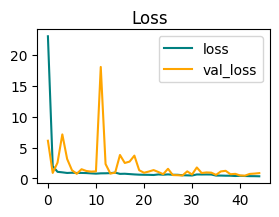

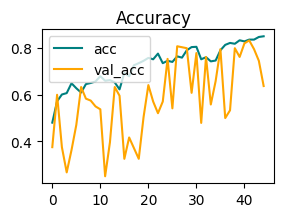

Fold Training Time: 5 hour(s) and 47 mins
Precision: 85.77777743339539  -  Recall: 80.41666746139526
Accuracy: 83.33333134651184
F1Score: Building 74.38015747070312 | Plant 91.60305786132812 | Road 93.10344696044922 | Vehicle 73.21428680419922
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/b2f39cb5-cbd8-4446-86f6-c414d8a458e9
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 21.7044 - accuracy: 0.4637
Epoch 1: val_loss improved from inf to 6.47562, saving model to ./checkpoints/V4.1.2\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-3\assets


210/210 [==============================] - 440s 2s/step - loss: 21.7044 - accuracy: 0.4637 - val_loss: 6.4756 - val_accuracy: 0.3792 - lr: 0.0015
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.7693 - accuracy: 0.5720
Epoch 2: val_loss improved from 6.47562 to 0.94820, saving model to ./checkpoints/V4.1.2\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-3\assets


210/210 [==============================] - 432s 2s/step - loss: 1.7693 - accuracy: 0.5720 - val_loss: 0.9482 - val_accuracy: 0.6000 - lr: 0.0015
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 1.0784 - accuracy: 0.6220
Epoch 3: val_loss did not improve from 0.94820
210/210 [==============================] - 421s 2s/step - loss: 1.0784 - accuracy: 0.6220 - val_loss: 1.0500 - val_accuracy: 0.6458 - lr: 0.0015
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 1.0374 - accuracy: 0.6137
Epoch 4: val_loss improved from 0.94820 to 0.79690, saving model to ./checkpoints/V4.1.2\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-3\assets


210/210 [==============================] - 439s 2s/step - loss: 1.0374 - accuracy: 0.6137 - val_loss: 0.7969 - val_accuracy: 0.6375 - lr: 0.0015
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 0.9192 - accuracy: 0.6357
Epoch 5: val_loss did not improve from 0.79690
210/210 [==============================] - 424s 2s/step - loss: 0.9192 - accuracy: 0.6357 - val_loss: 1.0527 - val_accuracy: 0.5875 - lr: 0.0015
Epoch 6/45
210/210 [==============================] - ETA: 0s - loss: 0.9035 - accuracy: 0.6208
Epoch 6: val_loss did not improve from 0.79690
210/210 [==============================] - 424s 2s/step - loss: 0.9035 - accuracy: 0.6208 - val_loss: 0.8039 - val_accuracy: 0.6375 - lr: 0.0015
Epoch 7/45
210/210 [==============================] - ETA: 0s - loss: 0.8882 - accuracy: 0.6423
Epoch 7: val_loss did not improve from 0.79690
210/210 [==============================] - 424s 2s/step - loss: 0.8882 - accuracy: 0.6423 - val_loss: 1.5190 - val_accuracy: 0.4708 - lr

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-3\assets


210/210 [==============================] - 433s 2s/step - loss: 0.8558 - accuracy: 0.6649 - val_loss: 0.7385 - val_accuracy: 0.6542 - lr: 0.0015
Epoch 9/45
210/210 [==============================] - ETA: 0s - loss: 0.8767 - accuracy: 0.6310
Epoch 9: val_loss did not improve from 0.73853
210/210 [==============================] - 424s 2s/step - loss: 0.8767 - accuracy: 0.6310 - val_loss: 0.8357 - val_accuracy: 0.6083 - lr: 0.0015
Epoch 10/45
210/210 [==============================] - ETA: 0s - loss: 0.8688 - accuracy: 0.6530
Epoch 10: val_loss did not improve from 0.73853
210/210 [==============================] - 423s 2s/step - loss: 0.8688 - accuracy: 0.6530 - val_loss: 0.9892 - val_accuracy: 0.5458 - lr: 0.0015
Epoch 11/45
210/210 [==============================] - ETA: 0s - loss: 0.7831 - accuracy: 0.6470
Epoch 11: val_loss improved from 0.73853 to 0.64870, saving model to ./checkpoints/V4.1.2\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-3\assets


210/210 [==============================] - 432s 2s/step - loss: 0.7831 - accuracy: 0.6470 - val_loss: 0.6487 - val_accuracy: 0.7625 - lr: 0.0015
Epoch 12/45
210/210 [==============================] - ETA: 0s - loss: 0.7735 - accuracy: 0.6655
Epoch 12: val_loss did not improve from 0.64870
210/210 [==============================] - 423s 2s/step - loss: 0.7735 - accuracy: 0.6655 - val_loss: 0.7710 - val_accuracy: 0.6792 - lr: 0.0015
Epoch 13/45
210/210 [==============================] - ETA: 0s - loss: 0.7946 - accuracy: 0.6679
Epoch 13: val_loss did not improve from 0.64870
210/210 [==============================] - 426s 2s/step - loss: 0.7946 - accuracy: 0.6679 - val_loss: 3.8099 - val_accuracy: 0.3500 - lr: 0.0015
Epoch 14/45
210/210 [==============================] - ETA: 0s - loss: 0.7560 - accuracy: 0.6673
Epoch 14: val_loss did not improve from 0.64870
210/210 [==============================] - 424s 2s/step - loss: 0.7560 - accuracy: 0.6673 - val_loss: 0.6692 - val_accuracy: 0.691

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-3\assets


210/210 [==============================] - 434s 2s/step - loss: 0.6855 - accuracy: 0.7089 - val_loss: 0.5919 - val_accuracy: 0.7875 - lr: 0.0015
Epoch 18/45
210/210 [==============================] - ETA: 0s - loss: 0.7310 - accuracy: 0.7185
Epoch 18: val_loss did not improve from 0.59188
210/210 [==============================] - 424s 2s/step - loss: 0.7310 - accuracy: 0.7185 - val_loss: 1.3380 - val_accuracy: 0.5375 - lr: 0.0015
Epoch 19/45
210/210 [==============================] - ETA: 0s - loss: 0.7553 - accuracy: 0.7161
Epoch 19: val_loss did not improve from 0.59188
210/210 [==============================] - 424s 2s/step - loss: 0.7553 - accuracy: 0.7161 - val_loss: 1.8001 - val_accuracy: 0.4000 - lr: 0.0015
Epoch 20/45
210/210 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.7292
Epoch 20: val_loss improved from 0.59188 to 0.54315, saving model to ./checkpoints/V4.1.2\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-3\assets


210/210 [==============================] - 432s 2s/step - loss: 0.6910 - accuracy: 0.7292 - val_loss: 0.5432 - val_accuracy: 0.7917 - lr: 0.0015
Epoch 21/45
210/210 [==============================] - ETA: 0s - loss: 0.7367 - accuracy: 0.7107
Epoch 21: val_loss did not improve from 0.54315
210/210 [==============================] - 425s 2s/step - loss: 0.7367 - accuracy: 0.7107 - val_loss: 0.7367 - val_accuracy: 0.7542 - lr: 0.0015
Epoch 22/45
210/210 [==============================] - ETA: 0s - loss: 0.6654 - accuracy: 0.7286
Epoch 22: val_loss did not improve from 0.54315
210/210 [==============================] - 425s 2s/step - loss: 0.6654 - accuracy: 0.7286 - val_loss: 1.3059 - val_accuracy: 0.5250 - lr: 0.0015
Epoch 23/45
210/210 [==============================] - ETA: 0s - loss: 0.6483 - accuracy: 0.7399
Epoch 23: val_loss did not improve from 0.54315
210/210 [==============================] - 426s 2s/step - loss: 0.6483 - accuracy: 0.7399 - val_loss: 1.1196 - val_accuracy: 0.620

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-3\assets


210/210 [==============================] - 487s 2s/step - loss: 0.4745 - accuracy: 0.8173 - val_loss: 0.5132 - val_accuracy: 0.8042 - lr: 9.0000e-04
Epoch 32/45
210/210 [==============================] - ETA: 0s - loss: 0.4500 - accuracy: 0.8375
Epoch 32: val_loss improved from 0.51322 to 0.36918, saving model to ./checkpoints/V4.1.2\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-3\assets


210/210 [==============================] - 580s 3s/step - loss: 0.4500 - accuracy: 0.8375 - val_loss: 0.3692 - val_accuracy: 0.8667 - lr: 9.0000e-04
Epoch 33/45
210/210 [==============================] - ETA: 0s - loss: 0.4422 - accuracy: 0.8202
Epoch 33: val_loss did not improve from 0.36918
210/210 [==============================] - 600s 3s/step - loss: 0.4422 - accuracy: 0.8202 - val_loss: 0.5762 - val_accuracy: 0.8250 - lr: 9.0000e-04
Epoch 34/45
210/210 [==============================] - ETA: 0s - loss: 0.4661 - accuracy: 0.8232
Epoch 34: val_loss did not improve from 0.36918
210/210 [==============================] - 541s 3s/step - loss: 0.4661 - accuracy: 0.8232 - val_loss: 0.6175 - val_accuracy: 0.8083 - lr: 9.0000e-04
Epoch 35/45
210/210 [==============================] - ETA: 0s - loss: 0.4192 - accuracy: 0.8298
Epoch 35: val_loss did not improve from 0.36918
210/210 [==============================] - 568s 3s/step - loss: 0.4192 - accuracy: 0.8298 - val_loss: 0.3898 - val_acc

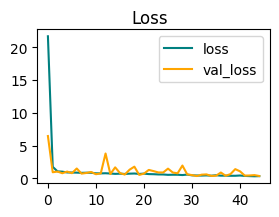

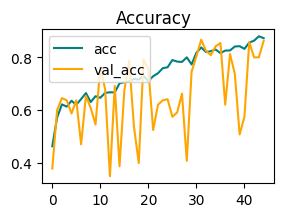

Fold Training Time: 5 hour(s) and 50 mins
Precision: 90.32257795333862  -  Recall: 81.66666626930237
Accuracy: 86.66666746139526
F1Score: Building 77.19297790527344 | Plant 94.30894470214844 | Road 92.91338348388672 | Vehicle 81.03447723388672
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/77b94067-f441-4c4b-8258-df4cb97be6ed
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 22.9895 - accuracy: 0.4690
Epoch 1: val_loss improved from inf to 2.30331, saving model to ./checkpoints/V4.1.2\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-4\assets


210/210 [==============================] - 466s 2s/step - loss: 22.9895 - accuracy: 0.4690 - val_loss: 2.3033 - val_accuracy: 0.4292 - lr: 0.0015
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.5265 - accuracy: 0.5792
Epoch 2: val_loss improved from 2.30331 to 1.54033, saving model to ./checkpoints/V4.1.2\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-4\assets


210/210 [==============================] - 444s 2s/step - loss: 1.5265 - accuracy: 0.5792 - val_loss: 1.5403 - val_accuracy: 0.4167 - lr: 0.0015
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 0.9689 - accuracy: 0.6298
Epoch 3: val_loss improved from 1.54033 to 0.92536, saving model to ./checkpoints/V4.1.2\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-4\assets


210/210 [==============================] - 445s 2s/step - loss: 0.9689 - accuracy: 0.6298 - val_loss: 0.9254 - val_accuracy: 0.6542 - lr: 0.0015
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 0.8933 - accuracy: 0.6226
Epoch 4: val_loss did not improve from 0.92536
210/210 [==============================] - 435s 2s/step - loss: 0.8933 - accuracy: 0.6226 - val_loss: 1.1184 - val_accuracy: 0.7000 - lr: 0.0015
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 0.8752 - accuracy: 0.6345
Epoch 5: val_loss did not improve from 0.92536
210/210 [==============================] - 435s 2s/step - loss: 0.8752 - accuracy: 0.6345 - val_loss: 1.8058 - val_accuracy: 0.4667 - lr: 0.0015
Epoch 6/45
210/210 [==============================] - ETA: 0s - loss: 0.8225 - accuracy: 0.6619
Epoch 6: val_loss did not improve from 0.92536
210/210 [==============================] - 433s 2s/step - loss: 0.8225 - accuracy: 0.6619 - val_loss: 3.4989 - val_accuracy: 0.3833 - lr

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-4\assets


210/210 [==============================] - 538s 3s/step - loss: 0.8052 - accuracy: 0.6899 - val_loss: 0.7297 - val_accuracy: 0.7583 - lr: 0.0015
Epoch 10/45
210/210 [==============================] - ETA: 0s - loss: 0.8101 - accuracy: 0.6649
Epoch 10: val_loss did not improve from 0.72975
210/210 [==============================] - 511s 2s/step - loss: 0.8101 - accuracy: 0.6649 - val_loss: 1.0996 - val_accuracy: 0.5750 - lr: 0.0015
Epoch 11/45
210/210 [==============================] - ETA: 0s - loss: 0.7567 - accuracy: 0.6935
Epoch 11: val_loss did not improve from 0.72975
210/210 [==============================] - 505s 2s/step - loss: 0.7567 - accuracy: 0.6935 - val_loss: 0.8235 - val_accuracy: 0.6792 - lr: 0.0015
Epoch 12/45
210/210 [==============================] - ETA: 0s - loss: 0.7481 - accuracy: 0.6970
Epoch 12: val_loss did not improve from 0.72975
210/210 [==============================] - 484s 2s/step - loss: 0.7481 - accuracy: 0.6970 - val_loss: 1.2366 - val_accuracy: 0.625

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-4\assets


210/210 [==============================] - 421s 2s/step - loss: 0.5796 - accuracy: 0.7583 - val_loss: 0.5853 - val_accuracy: 0.7542 - lr: 9.0000e-04
Epoch 22/45
210/210 [==============================] - ETA: 0s - loss: 0.5933 - accuracy: 0.7667
Epoch 22: val_loss did not improve from 0.58532
210/210 [==============================] - 408s 2s/step - loss: 0.5933 - accuracy: 0.7667 - val_loss: 1.2490 - val_accuracy: 0.6083 - lr: 9.0000e-04
Epoch 23/45
210/210 [==============================] - ETA: 0s - loss: 0.5427 - accuracy: 0.7756
Epoch 23: val_loss improved from 0.58532 to 0.52909, saving model to ./checkpoints/V4.1.2\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-4\assets


210/210 [==============================] - 417s 2s/step - loss: 0.5427 - accuracy: 0.7756 - val_loss: 0.5291 - val_accuracy: 0.8167 - lr: 9.0000e-04
Epoch 24/45
210/210 [==============================] - ETA: 0s - loss: 0.6163 - accuracy: 0.7506
Epoch 24: val_loss did not improve from 0.52909
210/210 [==============================] - 408s 2s/step - loss: 0.6163 - accuracy: 0.7506 - val_loss: 1.0035 - val_accuracy: 0.6542 - lr: 9.0000e-04
Epoch 25/45
210/210 [==============================] - ETA: 0s - loss: 0.5798 - accuracy: 0.7554
Epoch 25: val_loss did not improve from 0.52909
210/210 [==============================] - 410s 2s/step - loss: 0.5798 - accuracy: 0.7554 - val_loss: 0.7390 - val_accuracy: 0.7000 - lr: 9.0000e-04
Epoch 26/45
210/210 [==============================] - ETA: 0s - loss: 0.5356 - accuracy: 0.7768
Epoch 26: val_loss did not improve from 0.52909
210/210 [==============================] - 409s 2s/step - loss: 0.5356 - accuracy: 0.7768 - val_loss: 1.3243 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-4\assets


210/210 [==============================] - 415s 2s/step - loss: 0.5760 - accuracy: 0.7726 - val_loss: 0.3826 - val_accuracy: 0.8750 - lr: 9.0000e-04
Epoch 29/45
210/210 [==============================] - ETA: 0s - loss: 0.5307 - accuracy: 0.7917
Epoch 29: val_loss improved from 0.38258 to 0.34883, saving model to ./checkpoints/V4.1.2\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-4\assets


210/210 [==============================] - 425s 2s/step - loss: 0.5307 - accuracy: 0.7917 - val_loss: 0.3488 - val_accuracy: 0.8500 - lr: 9.0000e-04
Epoch 30/45
210/210 [==============================] - ETA: 0s - loss: 0.5168 - accuracy: 0.7929
Epoch 30: val_loss did not improve from 0.34883
210/210 [==============================] - 409s 2s/step - loss: 0.5168 - accuracy: 0.7929 - val_loss: 1.0977 - val_accuracy: 0.5917 - lr: 9.0000e-04
Epoch 31/45
210/210 [==============================] - ETA: 0s - loss: 0.4910 - accuracy: 0.8018
Epoch 31: val_loss did not improve from 0.34883
210/210 [==============================] - 409s 2s/step - loss: 0.4910 - accuracy: 0.8018 - val_loss: 0.5223 - val_accuracy: 0.8208 - lr: 9.0000e-04
Epoch 32/45
210/210 [==============================] - ETA: 0s - loss: 0.4720 - accuracy: 0.8173
Epoch 32: val_loss did not improve from 0.34883
210/210 [==============================] - 408s 2s/step - loss: 0.4720 - accuracy: 0.8173 - val_loss: 0.5187 - val_acc

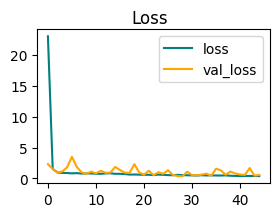

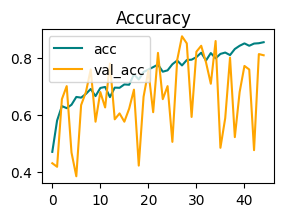

Fold Training Time: 5 hour(s) and 26 mins
Precision: 88.64628672599792  -  Recall: 84.58333611488342
Accuracy: 85.00000238418579
F1Score: Building 73.17073059082031 | Plant 90.43478393554688 | Road 94.91525268554688 | Vehicle 82.25807189941406
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/4f5bce7c-9b95-4992-b85a-1397fef03f33
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 25.3028 - accuracy: 0.4500
Epoch 1: val_loss improved from inf to 2.84351, saving model to ./checkpoints/V4.1.2\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-5\assets


210/210 [==============================] - 466s 2s/step - loss: 25.3028 - accuracy: 0.4500 - val_loss: 2.8435 - val_accuracy: 0.4333 - lr: 0.0015
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.3854 - accuracy: 0.5143
Epoch 2: val_loss improved from 2.84351 to 0.82449, saving model to ./checkpoints/V4.1.2\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-5\assets


210/210 [==============================] - 460s 2s/step - loss: 1.3854 - accuracy: 0.5143 - val_loss: 0.8245 - val_accuracy: 0.5875 - lr: 0.0015
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 1.0130 - accuracy: 0.5589
Epoch 3: val_loss improved from 0.82449 to 0.78230, saving model to ./checkpoints/V4.1.2\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-5\assets


210/210 [==============================] - 465s 2s/step - loss: 1.0130 - accuracy: 0.5589 - val_loss: 0.7823 - val_accuracy: 0.7125 - lr: 0.0015
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 1.0168 - accuracy: 0.5923
Epoch 4: val_loss improved from 0.78230 to 0.69968, saving model to ./checkpoints/V4.1.2\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-5\assets


210/210 [==============================] - 453s 2s/step - loss: 1.0168 - accuracy: 0.5923 - val_loss: 0.6997 - val_accuracy: 0.6792 - lr: 0.0015
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 0.9599 - accuracy: 0.6042
Epoch 5: val_loss did not improve from 0.69968
210/210 [==============================] - 441s 2s/step - loss: 0.9599 - accuracy: 0.6042 - val_loss: 0.7360 - val_accuracy: 0.7375 - lr: 0.0015
Epoch 6/45
210/210 [==============================] - ETA: 0s - loss: 1.0292 - accuracy: 0.5571
Epoch 6: val_loss did not improve from 0.69968
210/210 [==============================] - 442s 2s/step - loss: 1.0292 - accuracy: 0.5571 - val_loss: 0.8083 - val_accuracy: 0.6917 - lr: 0.0015
Epoch 7/45
210/210 [==============================] - ETA: 0s - loss: 0.9883 - accuracy: 0.5595
Epoch 7: val_loss did not improve from 0.69968
210/210 [==============================] - 439s 2s/step - loss: 0.9883 - accuracy: 0.5595 - val_loss: 2.2697 - val_accuracy: 0.4917 - lr

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-5\assets


210/210 [==============================] - 450s 2s/step - loss: 0.8315 - accuracy: 0.6280 - val_loss: 0.5995 - val_accuracy: 0.6958 - lr: 9.0000e-04
Epoch 24/45
210/210 [==============================] - ETA: 0s - loss: 0.8428 - accuracy: 0.6113
Epoch 24: val_loss did not improve from 0.59952
210/210 [==============================] - 439s 2s/step - loss: 0.8428 - accuracy: 0.6113 - val_loss: 1.1764 - val_accuracy: 0.4917 - lr: 9.0000e-04
Epoch 25/45
210/210 [==============================] - ETA: 0s - loss: 0.7920 - accuracy: 0.6304
Epoch 25: val_loss did not improve from 0.59952
210/210 [==============================] - 441s 2s/step - loss: 0.7920 - accuracy: 0.6304 - val_loss: 0.6538 - val_accuracy: 0.6958 - lr: 9.0000e-04
Epoch 26/45
210/210 [==============================] - ETA: 0s - loss: 0.7887 - accuracy: 0.6387
Epoch 26: val_loss did not improve from 0.59952
210/210 [==============================] - 441s 2s/step - loss: 0.7887 - accuracy: 0.6387 - val_loss: 1.9668 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-5\assets


210/210 [==============================] - 450s 2s/step - loss: 0.5813 - accuracy: 0.7500 - val_loss: 0.4752 - val_accuracy: 0.8208 - lr: 5.4000e-04
Epoch 38/45
210/210 [==============================] - ETA: 0s - loss: 0.6170 - accuracy: 0.7351
Epoch 38: val_loss did not improve from 0.47518
210/210 [==============================] - 440s 2s/step - loss: 0.6170 - accuracy: 0.7351 - val_loss: 0.8514 - val_accuracy: 0.6208 - lr: 5.4000e-04
Epoch 39/45
210/210 [==============================] - ETA: 0s - loss: 0.6359 - accuracy: 0.7464
Epoch 39: val_loss did not improve from 0.47518
210/210 [==============================] - 440s 2s/step - loss: 0.6359 - accuracy: 0.7464 - val_loss: 0.8897 - val_accuracy: 0.6167 - lr: 5.4000e-04
Epoch 40/45
210/210 [==============================] - ETA: 0s - loss: 0.5521 - accuracy: 0.7619
Epoch 40: val_loss did not improve from 0.47518
210/210 [==============================] - 439s 2s/step - loss: 0.5521 - accuracy: 0.7619 - val_loss: 0.4816 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-5\assets


210/210 [==============================] - 448s 2s/step - loss: 0.5774 - accuracy: 0.7589 - val_loss: 0.4723 - val_accuracy: 0.8125 - lr: 5.4000e-04
Epoch 42/45
210/210 [==============================] - ETA: 0s - loss: 0.5545 - accuracy: 0.7744
Epoch 42: val_loss did not improve from 0.47229
210/210 [==============================] - 440s 2s/step - loss: 0.5545 - accuracy: 0.7744 - val_loss: 0.6648 - val_accuracy: 0.7458 - lr: 5.4000e-04
Epoch 43/45
210/210 [==============================] - ETA: 0s - loss: 0.5736 - accuracy: 0.7643
Epoch 43: val_loss improved from 0.47229 to 0.45805, saving model to ./checkpoints/V4.1.2\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-5\assets


210/210 [==============================] - 445s 2s/step - loss: 0.5736 - accuracy: 0.7643 - val_loss: 0.4580 - val_accuracy: 0.8375 - lr: 5.4000e-04
Epoch 44/45
210/210 [==============================] - ETA: 0s - loss: 0.5479 - accuracy: 0.7702
Epoch 44: val_loss did not improve from 0.45805
210/210 [==============================] - 438s 2s/step - loss: 0.5479 - accuracy: 0.7702 - val_loss: 1.9255 - val_accuracy: 0.4167 - lr: 5.4000e-04
Epoch 45/45
210/210 [==============================] - ETA: 0s - loss: 0.5642 - accuracy: 0.7726
Epoch 45: val_loss did not improve from 0.45805
210/210 [==============================] - 437s 2s/step - loss: 0.5642 - accuracy: 0.7726 - val_loss: 2.0951 - val_accuracy: 0.3375 - lr: 5.4000e-04


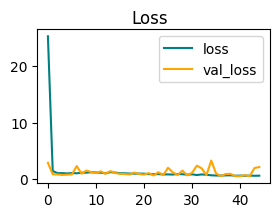

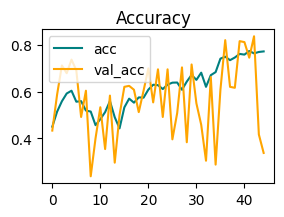

Fold Training Time: 5 hour(s) and 32 mins
Precision: 86.32075190544128  -  Recall: 76.2499988079071
Accuracy: 83.74999761581421
F1Score: Building 74.24242401123047 | Plant 94.82758331298828 | Road 92.56198120117188 | Vehicle 73.87387084960938
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/5db11ebf-5398-4fcc-87fe-e34bbd308733
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 19.3633 - accuracy: 0.5149
Epoch 1: val_loss improved from inf to 3.99501, saving model to ./checkpoints/V4.1.2\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-6\assets


210/210 [==============================] - 471s 2s/step - loss: 19.3633 - accuracy: 0.5149 - val_loss: 3.9950 - val_accuracy: 0.3875 - lr: 0.0015
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.6293 - accuracy: 0.5655
Epoch 2: val_loss improved from 3.99501 to 1.07568, saving model to ./checkpoints/V4.1.2\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-6\assets


210/210 [==============================] - 445s 2s/step - loss: 1.6293 - accuracy: 0.5655 - val_loss: 1.0757 - val_accuracy: 0.5500 - lr: 0.0015
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 1.0105 - accuracy: 0.5750
Epoch 3: val_loss improved from 1.07568 to 0.82262, saving model to ./checkpoints/V4.1.2\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-6\assets


210/210 [==============================] - 446s 2s/step - loss: 1.0105 - accuracy: 0.5750 - val_loss: 0.8226 - val_accuracy: 0.6583 - lr: 0.0015
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 0.9250 - accuracy: 0.5917
Epoch 4: val_loss improved from 0.82262 to 0.77196, saving model to ./checkpoints/V4.1.2\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-6\assets


210/210 [==============================] - 445s 2s/step - loss: 0.9250 - accuracy: 0.5917 - val_loss: 0.7720 - val_accuracy: 0.6667 - lr: 0.0015
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 0.9808 - accuracy: 0.5625
Epoch 5: val_loss did not improve from 0.77196
210/210 [==============================] - 438s 2s/step - loss: 0.9808 - accuracy: 0.5625 - val_loss: 1.1619 - val_accuracy: 0.4625 - lr: 0.0015
Epoch 6/45
210/210 [==============================] - ETA: 0s - loss: 1.0796 - accuracy: 0.5113
Epoch 6: val_loss did not improve from 0.77196
210/210 [==============================] - 436s 2s/step - loss: 1.0796 - accuracy: 0.5113 - val_loss: 1.4146 - val_accuracy: 0.6000 - lr: 0.0015
Epoch 7/45
210/210 [==============================] - ETA: 0s - loss: 1.0368 - accuracy: 0.5530
Epoch 7: val_loss did not improve from 0.77196
210/210 [==============================] - 437s 2s/step - loss: 1.0368 - accuracy: 0.5530 - val_loss: 0.8521 - val_accuracy: 0.6583 - lr

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-6\assets


210/210 [==============================] - 456s 2s/step - loss: 0.9556 - accuracy: 0.6006 - val_loss: 0.7482 - val_accuracy: 0.7208 - lr: 9.0000e-04
Epoch 17/45
210/210 [==============================] - ETA: 0s - loss: 0.8956 - accuracy: 0.6006
Epoch 17: val_loss did not improve from 0.74817
210/210 [==============================] - 439s 2s/step - loss: 0.8956 - accuracy: 0.6006 - val_loss: 1.2616 - val_accuracy: 0.6042 - lr: 9.0000e-04
Epoch 18/45
210/210 [==============================] - ETA: 0s - loss: 0.9172 - accuracy: 0.6048
Epoch 18: val_loss did not improve from 0.74817
210/210 [==============================] - 440s 2s/step - loss: 0.9172 - accuracy: 0.6048 - val_loss: 1.3357 - val_accuracy: 0.4083 - lr: 9.0000e-04
Epoch 19/45
210/210 [==============================] - ETA: 0s - loss: 0.9919 - accuracy: 0.5881
Epoch 19: val_loss did not improve from 0.74817
210/210 [==============================] - 438s 2s/step - loss: 0.9919 - accuracy: 0.5881 - val_loss: 1.5234 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-6\assets


210/210 [==============================] - 602s 3s/step - loss: 0.8098 - accuracy: 0.6643 - val_loss: 0.6792 - val_accuracy: 0.7750 - lr: 9.0000e-04
Epoch 27/45
210/210 [==============================] - ETA: 0s - loss: 0.8595 - accuracy: 0.6375
Epoch 27: val_loss did not improve from 0.67919
210/210 [==============================] - 527s 3s/step - loss: 0.8595 - accuracy: 0.6375 - val_loss: 0.8800 - val_accuracy: 0.6625 - lr: 9.0000e-04
Epoch 28/45
210/210 [==============================] - ETA: 0s - loss: 0.8341 - accuracy: 0.6530
Epoch 28: val_loss did not improve from 0.67919
210/210 [==============================] - 585s 3s/step - loss: 0.8341 - accuracy: 0.6530 - val_loss: 9.0936 - val_accuracy: 0.2625 - lr: 9.0000e-04
Epoch 29/45
210/210 [==============================] - ETA: 0s - loss: 1.0519 - accuracy: 0.5607
Epoch 29: val_loss did not improve from 0.67919
210/210 [==============================] - 565s 3s/step - loss: 1.0519 - accuracy: 0.5607 - val_loss: 0.9680 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-6\assets


210/210 [==============================] - 494s 2s/step - loss: 0.6925 - accuracy: 0.7208 - val_loss: 0.6524 - val_accuracy: 0.7833 - lr: 9.0000e-04
Epoch 35/45
210/210 [==============================] - ETA: 0s - loss: 0.7707 - accuracy: 0.6881
Epoch 35: val_loss did not improve from 0.65245
210/210 [==============================] - 484s 2s/step - loss: 0.7707 - accuracy: 0.6881 - val_loss: 0.8086 - val_accuracy: 0.6542 - lr: 9.0000e-04
Epoch 36/45
210/210 [==============================] - ETA: 0s - loss: 0.6395 - accuracy: 0.7339
Epoch 36: val_loss did not improve from 0.65245
210/210 [==============================] - 487s 2s/step - loss: 0.6395 - accuracy: 0.7339 - val_loss: 1.5849 - val_accuracy: 0.4250 - lr: 9.0000e-04
Epoch 37/45
210/210 [==============================] - ETA: 0s - loss: 0.7364 - accuracy: 0.7024
Epoch 37: val_loss did not improve from 0.65245
210/210 [==============================] - 465s 2s/step - loss: 0.7364 - accuracy: 0.7024 - val_loss: 0.8549 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-6\assets


210/210 [==============================] - 542s 3s/step - loss: 0.5973 - accuracy: 0.7583 - val_loss: 0.6078 - val_accuracy: 0.7833 - lr: 9.0000e-04
Epoch 43/45
210/210 [==============================] - ETA: 0s - loss: 0.6511 - accuracy: 0.7435
Epoch 43: val_loss improved from 0.60781 to 0.57503, saving model to ./checkpoints/V4.1.2\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-6\assets


210/210 [==============================] - 558s 3s/step - loss: 0.6511 - accuracy: 0.7435 - val_loss: 0.5750 - val_accuracy: 0.7417 - lr: 9.0000e-04
Epoch 44/45
210/210 [==============================] - ETA: 0s - loss: 0.5928 - accuracy: 0.7732
Epoch 44: val_loss did not improve from 0.57503
210/210 [==============================] - 507s 2s/step - loss: 0.5928 - accuracy: 0.7732 - val_loss: 1.1457 - val_accuracy: 0.5875 - lr: 9.0000e-04
Epoch 45/45
210/210 [==============================] - ETA: 0s - loss: 0.6610 - accuracy: 0.7256
Epoch 45: val_loss did not improve from 0.57503
210/210 [==============================] - 551s 3s/step - loss: 0.6610 - accuracy: 0.7256 - val_loss: 1.1011 - val_accuracy: 0.5333 - lr: 9.0000e-04


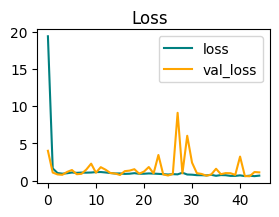

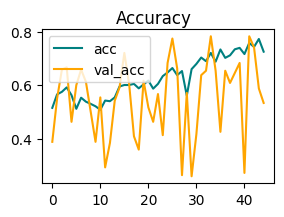

Fold Training Time: 6 hour(s) and 2 mins
Precision: 83.75634551048279  -  Recall: 68.75
Accuracy: 74.16666746139526
F1Score: Building 61.068702697753906 | Plant 88.33333587646484 | Road 84.68468475341797 | Vehicle 64.40677642822266
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/cc7a7bde-d9f4-4199-bbf3-2c862b363fd7
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 20.2811 - accuracy: 0.4917
Epoch 1: val_loss improved from inf to 4.19714, saving model to ./checkpoints/V4.1.2\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-7\assets


210/210 [==============================] - 613s 3s/step - loss: 20.2811 - accuracy: 0.4917 - val_loss: 4.1971 - val_accuracy: 0.3250 - lr: 0.0015
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.6109 - accuracy: 0.5917
Epoch 2: val_loss improved from 4.19714 to 0.87423, saving model to ./checkpoints/V4.1.2\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-7\assets


210/210 [==============================] - 539s 3s/step - loss: 1.6109 - accuracy: 0.5917 - val_loss: 0.8742 - val_accuracy: 0.6333 - lr: 0.0015
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 0.9814 - accuracy: 0.6357
Epoch 3: val_loss did not improve from 0.87423
210/210 [==============================] - 502s 2s/step - loss: 0.9814 - accuracy: 0.6357 - val_loss: 0.9673 - val_accuracy: 0.6375 - lr: 0.0015
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 0.8907 - accuracy: 0.6470
Epoch 4: val_loss improved from 0.87423 to 0.68817, saving model to ./checkpoints/V4.1.2\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-7\assets


210/210 [==============================] - 570s 3s/step - loss: 0.8907 - accuracy: 0.6470 - val_loss: 0.6882 - val_accuracy: 0.7250 - lr: 0.0015
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 0.8767 - accuracy: 0.6595
Epoch 5: val_loss did not improve from 0.68817
210/210 [==============================] - 557s 3s/step - loss: 0.8767 - accuracy: 0.6595 - val_loss: 1.5746 - val_accuracy: 0.5958 - lr: 0.0015
Epoch 6/45
210/210 [==============================] - ETA: 0s - loss: 0.8660 - accuracy: 0.6393
Epoch 6: val_loss did not improve from 0.68817
210/210 [==============================] - 530s 3s/step - loss: 0.8660 - accuracy: 0.6393 - val_loss: 0.9437 - val_accuracy: 0.6625 - lr: 0.0015
Epoch 7/45
210/210 [==============================] - ETA: 0s - loss: 0.8819 - accuracy: 0.6565
Epoch 7: val_loss improved from 0.68817 to 0.65241, saving model to ./checkpoints/V4.1.2\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-7\assets


210/210 [==============================] - 524s 2s/step - loss: 0.8819 - accuracy: 0.6565 - val_loss: 0.6524 - val_accuracy: 0.7208 - lr: 0.0015
Epoch 8/45
210/210 [==============================] - ETA: 0s - loss: 0.8015 - accuracy: 0.6518
Epoch 8: val_loss did not improve from 0.65241
210/210 [==============================] - 509s 2s/step - loss: 0.8015 - accuracy: 0.6518 - val_loss: 0.8293 - val_accuracy: 0.6708 - lr: 0.0015
Epoch 9/45
210/210 [==============================] - ETA: 0s - loss: 0.8736 - accuracy: 0.6345
Epoch 9: val_loss did not improve from 0.65241
210/210 [==============================] - 513s 2s/step - loss: 0.8736 - accuracy: 0.6345 - val_loss: 0.7798 - val_accuracy: 0.6417 - lr: 0.0015
Epoch 10/45
210/210 [==============================] - ETA: 0s - loss: 0.8631 - accuracy: 0.6381
Epoch 10: val_loss did not improve from 0.65241
210/210 [==============================] - 509s 2s/step - loss: 0.8631 - accuracy: 0.6381 - val_loss: 0.7451 - val_accuracy: 0.6292 - 

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-7\assets


210/210 [==============================] - 828s 4s/step - loss: 0.6832 - accuracy: 0.7417 - val_loss: 0.5164 - val_accuracy: 0.7833 - lr: 0.0015
Epoch 18/45
210/210 [==============================] - ETA: 0s - loss: 0.6426 - accuracy: 0.7548
Epoch 18: val_loss did not improve from 0.51637
210/210 [==============================] - 644s 3s/step - loss: 0.6426 - accuracy: 0.7548 - val_loss: 0.5623 - val_accuracy: 0.7708 - lr: 0.0015
Epoch 19/45
210/210 [==============================] - ETA: 0s - loss: 0.6185 - accuracy: 0.7637
Epoch 19: val_loss improved from 0.51637 to 0.51055, saving model to ./checkpoints/V4.1.2\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-7\assets


210/210 [==============================] - 701s 3s/step - loss: 0.6185 - accuracy: 0.7637 - val_loss: 0.5105 - val_accuracy: 0.8000 - lr: 0.0015
Epoch 20/45
210/210 [==============================] - ETA: 0s - loss: 0.6399 - accuracy: 0.7583
Epoch 20: val_loss did not improve from 0.51055
210/210 [==============================] - 553s 3s/step - loss: 0.6399 - accuracy: 0.7583 - val_loss: 0.9914 - val_accuracy: 0.5792 - lr: 0.0015
Epoch 21/45
210/210 [==============================] - ETA: 0s - loss: 0.7310 - accuracy: 0.7167
Epoch 21: val_loss did not improve from 0.51055
210/210 [==============================] - 546s 3s/step - loss: 0.7310 - accuracy: 0.7167 - val_loss: 1.9005 - val_accuracy: 0.4208 - lr: 0.0015
Epoch 22/45
210/210 [==============================] - ETA: 0s - loss: 0.5418 - accuracy: 0.7851
Epoch 22: val_loss did not improve from 0.51055
210/210 [==============================] - 522s 2s/step - loss: 0.5418 - accuracy: 0.7851 - val_loss: 0.5760 - val_accuracy: 0.775

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-7\assets


210/210 [==============================] - 529s 3s/step - loss: 0.4767 - accuracy: 0.8173 - val_loss: 0.4627 - val_accuracy: 0.8208 - lr: 9.0000e-04
Epoch 34/45
210/210 [==============================] - ETA: 0s - loss: 0.4421 - accuracy: 0.8262
Epoch 34: val_loss did not improve from 0.46271
210/210 [==============================] - 537s 3s/step - loss: 0.4421 - accuracy: 0.8262 - val_loss: 1.4662 - val_accuracy: 0.5875 - lr: 9.0000e-04
Epoch 35/45
210/210 [==============================] - ETA: 0s - loss: 0.5056 - accuracy: 0.8185
Epoch 35: val_loss did not improve from 0.46271
210/210 [==============================] - 484s 2s/step - loss: 0.5056 - accuracy: 0.8185 - val_loss: 0.9117 - val_accuracy: 0.7167 - lr: 9.0000e-04
Epoch 36/45
210/210 [==============================] - ETA: 0s - loss: 0.4600 - accuracy: 0.8232
Epoch 36: val_loss did not improve from 0.46271
210/210 [==============================] - 463s 2s/step - loss: 0.4600 - accuracy: 0.8232 - val_loss: 0.8989 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.2\FOLD-7\assets


210/210 [==============================] - 550s 3s/step - loss: 0.4215 - accuracy: 0.8315 - val_loss: 0.4494 - val_accuracy: 0.8208 - lr: 9.0000e-04
Epoch 40/45
210/210 [==============================] - ETA: 0s - loss: 0.4593 - accuracy: 0.8321
Epoch 40: val_loss did not improve from 0.44939
210/210 [==============================] - 525s 3s/step - loss: 0.4593 - accuracy: 0.8321 - val_loss: 0.5389 - val_accuracy: 0.8042 - lr: 9.0000e-04
Epoch 41/45
210/210 [==============================] - ETA: 0s - loss: 0.4068 - accuracy: 0.8405
Epoch 41: val_loss did not improve from 0.44939
210/210 [==============================] - 542s 3s/step - loss: 0.4068 - accuracy: 0.8405 - val_loss: 0.5636 - val_accuracy: 0.7708 - lr: 9.0000e-04
Epoch 42/45
210/210 [==============================] - ETA: 0s - loss: 0.3805 - accuracy: 0.8476
Epoch 42: val_loss did not improve from 0.44939
210/210 [==============================] - 484s 2s/step - loss: 0.3805 - accuracy: 0.8476 - val_loss: 1.1748 - val_acc

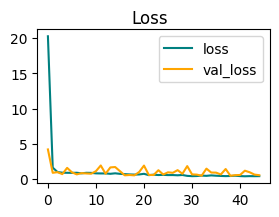

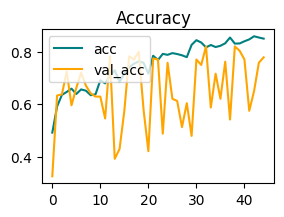

Fold Training Time: 6 hour(s) and 42 mins
Precision: 83.55555534362793  -  Recall: 78.33333611488342
Accuracy: 82.08333253860474
F1Score: Building 70.1754379272461 | Plant 88.18897247314453 | Road 93.22034454345703 | Vehicle 76.03305053710938
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
Total Training Time: 46 hour(s) and 28 mins


In [48]:
# ============================
# Log performance of each fold
# ============================

precisions = []
recalls = []
accuracies = []
f1_blds = []
f1_plants = []
f1_roads = []
f1_vhcls = []

counter = 0
start = perf_counter()
for train, test in kfold.split(train_x, train_y):
    start_fold = perf_counter()

    run = neptune.init_run(
        name= f"{model_name}-FOLD_{counter}",
        project=project_name,
        mode="offline"     # To prevent issue when internet sucks. Just manually sync it
    )  # your credentials

    run["parameters"] = params
    model = make_model(params)
    cat_y = tf.keras.utils.to_categorical(train_y)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_x[train], cat_y[train]))
    train_fold = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), seed=1).batch(params['batch_size'])
    
    test_dataset = tf.data.Dataset.from_tensor_slices((train_x[test], cat_y[test]))
    test_fold = test_dataset.shuffle(buffer_size=test_dataset.cardinality(), seed=1).batch(params['batch_size'])
    
    hist = model.fit(train_fold, 
                     validation_data=test_fold,
                     batch_size=params['batch_size'],
                     epochs=params['epochs'],
                     verbose=1,
                     callbacks=create_callbacks(counter))
    end_fold = perf_counter()

    # PLOTTING ==================================================
    run["fig-train_loss"].upload(plot_loss(hist))
    run["fig-train_acc"].upload(plot_acc(hist))
    
    # EVALUATING ==================================================
    model = tf.keras.models.load_model(checkpoint_path + str(counter))
    
    pre = Precision()
    rec = Recall()
    c_acc = CategoricalAccuracy()
    f1_score = F1Score()
    for batch in test_fold.as_numpy_iterator():
        X, y = batch
        yhat = model.predict(X, verbose=0)
        f1_score.update_state(y, yhat)
        pre.update_state(y, yhat)
        rec.update_state(y, yhat)
        c_acc.update_state(y, yhat)
        
    precisions.append(pre.result().numpy() * 100)
    recalls.append(rec.result().numpy() * 100)
    accuracies.append(c_acc.result().numpy() * 100)
    f1_s = f1_score.result().numpy() * 100
    
    f1_blds.append(f1_s[0])
    f1_plants.append(f1_s[1])
    f1_roads.append(f1_s[2])
    f1_vhcls.append(f1_s[3])
    
    run["eval/ACC/"] = accuracies[counter]
    run["eval/REC/"] = recalls[counter]
    run["eval/PRE/"] = precisions[counter]
    run["eval/F1-Bld"] = f1_blds[counter]
    run["eval/F1-Plant"] = f1_plants[counter]
    run["eval/F1-Road"] = f1_roads[counter]
    run["eval/F1-Vhcl"] = f1_vhcls[counter]

    # SAVE MODEL TO NEPTUNE AI =======================================
    model_save_path = f"./models/V4-1-2_Fold-{counter}.keras"
    model.save(model_save_path)
    run['/checkpoint/model'].upload(model_save_path)
    
    # PRINTING RESULTS ===========================================
    print(f'Fold Training Time: {math.floor((end_fold-start_fold)/3600) } hour(s) and {math.floor((end_fold-start_fold)/60)%60} mins')
    print(f'Precision: {precisions[counter]}  -  Recall: {recalls[counter]}')
    print(f'Accuracy: {accuracies[counter]}')
    print(f'F1Score: Building {f1_blds[counter]} | Plant {f1_plants[counter]} | Road {f1_roads[counter]} | Vehicle {f1_vhcls[counter]}')
    
    run.stop()
    
    counter += 1

end = perf_counter()

print(f'Total Training Time: {math.floor((end-start)/3600) } hour(s) and {math.floor((end-start)/60)%60} mins')

# Get Average Performance of Model

## Save to Neptune AI

In [49]:
run = neptune.init_run(
        name= f"{model_name}-AVG",
        project=project_name,
        mode='offline',
        # api_token=api_token, # Api token is saved in user's environemnt variables
    )  # your credentials

run["eval/PRE/"] = avg_rate(precisions)
run["eval/REC/"] = avg_rate(recalls)
run["eval/ACC/"] = avg_rate(accuracies)
run["eval/F1-Bld"] = avg_rate(f1_blds)
run["eval/F1-Plant"] = avg_rate(f1_plants)
run["eval/F1-Road"] = avg_rate(f1_roads)
run["eval/F1-Vhcl"] = avg_rate(f1_vhcls)

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: offline/3d7484a7-3b6a-4b86-8689-b4fe6fd070a3
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!


## Save to Tensorboard

In [50]:
# Command to access TensorBoard HParams:

# tensorboard --logdir PATH/logs/hparam_tuning
with tf.summary.create_file_writer(f'./logs/hparam_tuning/{model_name}').as_default():
    hparams = {
        'CONV_F1': 32,
        'CONV_F2': 32,
        'CONV_F3': 64,
        'CONV_F4': 64,
        'CONV_F5': 128,
        'CONV_F6': 128,
        'DROPOUT': 0.2,
        'D_UNITS_1': 640,
        'DROPOUT': 0.2,
        'D_UNITS_2': 256,
    }
    hp.hparams(hparams)
    tf.summary.scalar('PRE', avg_rate(precisions), step=1)
    tf.summary.scalar('REC', avg_rate(recalls), step=1)
    tf.summary.scalar('ACC', avg_rate(accuracies), step=1)
    tf.summary.scalar('F1 - Building', avg_rate(f1_blds), step=1)
    tf.summary.scalar('F1 - Plant', avg_rate(f1_plants), step=1)
    tf.summary.scalar('F1 - Road', avg_rate(f1_roads), step=1)
    tf.summary.scalar('F1 - Vehicle', avg_rate(f1_vhcls), step=1)

# Asd

# Others

In [ ]:
model= make_model()
model.fit(
    x_train,
    y_train,
    validation_data=(x_test,y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    callbacks=create_callbacks(0),
)

In [ ]:
true_test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
true_test_set = true_test_dataset.shuffle(buffer_size=true_test_dataset.cardinality(), seed=1).batch(64)

f1 = F1Score()
pre = Precision()
rec = Recall()
c_acc = CategoricalAccuracy()
for batch in true_test_set.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat_max = []
    for i in yhat:
        maxed = np.argmax(i)
        yhat_max.append(maxed)
    yhat = np.array(yhat_max)
    f1.update_state(y, yhat)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    c_acc.update_state(y, yhat)


In [ ]:
run["eval/ACC/"] = float(c_acc.result().numpy() * 100)
run["eval/REC/"] = float(rec.result().numpy() * 100)
run["eval/PRE/"] = float(pre.result().numpy() * 100)


In [ ]:
run.stop()

In [ ]:
eval_metrics = model.evaluate(x_test, y_test, verbose=0)
for j, metric in enumerate(eval_metrics):
    run["eval/AVG-ACC/{}".format(model.metrics_names[j])] = metric

run.stop()

In [ ]:
for j, metric in enumerate(eval_metrics):
    print(model.metrics_names[j])

## Neptune AI Notes